In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from scipy import stats
import math
import os
from mplsoccer import PyPizza, add_image, FontManager
import warnings
from urllib.request import urlopen

warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
font_normal = FontManager('https://raw.githubusercontent.com/google/fonts/main/apache/roboto/'
                          'Roboto%5Bwdth,wght%5D.ttf')
font_italic = FontManager('https://raw.githubusercontent.com/google/fonts/main/apache/roboto/'
                          'Roboto-Italic%5Bwdth,wght%5D.ttf')
font_bold = FontManager('https://raw.githubusercontent.com/google/fonts/main/apache/robotoslab/'
                        'RobotoSlab%5Bwght%5D.ttf')

In [3]:
def read_datasets(folder_path, dataset_types):
    dfs = {}
    
    for dataset_type in dataset_types:
        file_path = f'{folder_path}\\{dataset_type}\\{dataset_type}_325.csv'
        dfs[dataset_type] = pd.read_csv(file_path)
    
    return dfs

def drop_columns(df, columns):
    return df.drop(columns, axis=1)


In [4]:
# Merge all DataFrames on 'player.id'
def merge_dataframes(dfs, on_column):
    merged_df = dfs[0]
    
    for df in dfs[1:]:
        merged_df = pd.merge(merged_df, df, on=on_column, how='left')
    
    return merged_df



In [5]:
def get_params_list(merged_df: pd.DataFrame, cols_filter):
    params_df = merged_df[cols_filter]
    params = list(params_df.columns)
    return params

In [6]:
def get_player(player_id, merged_df, cols_filter):
    player = merged_df.loc[merged_df['player.id'] == player_id].reset_index()
    player = player[cols_filter]
    return list(player.loc[0])

def calculate_percintiles(params, merged_df, player):
    values = []
    for x in range(len(params)):
        values.append(math.floor(stats.percentileofscore(merged_df[params[x]], player[x])))
    return values

In [7]:
def create_pizza_plot(values, params, title, subtitle, slice_colors, text_colors, player_image, team_image):
    # color for the slices and text
    text_colors = text_colors[:len(params)]  # Ensure the correct number of text colors

    # instantiate PyPizza class
    baker = PyPizza(
        params=params,
        background_color="#ffffff",
        straight_line_color="#EBEBE9",
        straight_line_lw=1,
        last_circle_lw=0,
        other_circle_lw=0,
        inner_circle_size=20
    )

    # plot pizza
    fig, ax = baker.make_pizza(
        values,
        figsize=(8, 8.5),
        color_blank_space="same",
        slice_colors=slice_colors,
        value_colors=text_colors,
        value_bck_colors=slice_colors,
        blank_alpha=0.4,
        kwargs_slices=dict(edgecolor="#F2F2F2", zorder=2, linewidth=1),
        kwargs_params=dict(color="#000000", fontsize=9, va="center"),
        kwargs_values=dict(
            color="#000000", fontsize=9, zorder=3,
            bbox=dict(edgecolor="#000000", facecolor="cornflowerblue", boxstyle="round,pad=0.2", lw=1)
        )
    )

    # add title
    fig.text(
        0.515, 0.975, title, size=16,
        ha="center", fontproperties=font_bold.prop, color="#000000"
    )

    # add subtitle
    fig.text(
        0.515, 0.953,
        subtitle,
        size=13,
        ha="center", fontproperties=font_bold.prop, color="#000000"
    )

    # add credits
    CREDIT_1 = "data: sofascore.com"
    CREDIT_2 = "By: Victor Milhomem"

    fig.text(
        0.99, 0.02, f"{CREDIT_1}\n{CREDIT_2}", size=9,
        fontproperties=font_italic.prop, color="#000000",
        ha="right"
    )

    # add text
    fig.text(
        0.34, 0.925, "Attacking        Possession       Defending", size=14,
        fontproperties=font_bold.prop, color="#000000"
    )


    # add rectangles
    fig.patches.extend([
        plt.Rectangle(
            (0.31, 0.9225), 0.025, 0.021, fill=True, color="#1a78cf",
            transform=fig.transFigure, figure=fig
        ),
        plt.Rectangle(
            (0.462, 0.9225), 0.025, 0.021, fill=True, color="#ff9300",
            transform=fig.transFigure, figure=fig
        ),
        plt.Rectangle(
            (0.636, 0.9225), 0.025, 0.021, fill=True, color="#d70232",
            transform=fig.transFigure, figure=fig
        ),
    ])

    # add image
    
    ax_image = add_image(player_image, fig, left=0.473, bottom=0.4515, width=0.08, height=0.08)
    ax_image = add_image(team_image, fig, left=0., bottom=1, width=0.08, height=0.08)

    return fig, ax

# Example usage

In [8]:
folder_path = '325'
dataset_types = ['attack', 'defense', 'keepers', 'passing', 'others', 'players_info', 'teams_info']

dfs = read_datasets(folder_path, dataset_types)

attack_df = drop_columns(dfs['attack'], ['team.id', 'rating'])
defense_df = drop_columns(dfs['defense'], ['team.id', 'rating', 'cleanSheet'])
keepers_df = drop_columns(dfs['keepers'], ['team.id', 'rating'])
passing_df = drop_columns(dfs['passing'], ['team.id', 'rating'])
others_df = drop_columns(dfs['others'], ['team.id', 'rating'])
player_info_df = dfs['players_info']
teams_info_df = dfs['teams_info']

In [9]:
merged_df = merge_dataframes([player_info_df, attack_df, defense_df, keepers_df, passing_df, others_df], 'player.id')
merged_df.to_csv('merged_df.csv')
# filter player
merged_df = merged_df.loc[(merged_df['position'] == 'M') & (merged_df['appearances'] >= 5)]

In [10]:
cols_filter = merged_df.filter([
                            'expectedGoals',  'shotsOnTarget', 'successfulDribbles', 'totalShots', 'bigChancesMissed',
                            'bigChancesCreated',  'totalPasses', 'keyPasses', 'accuratePasses', 'accurateLongBalls',
                            'tackles', 'cleanSheet', 'interceptions', 'groundDuelsWon', 'aerialDuelsWon',
]).columns

params = get_params_list(merged_df, cols_filter)

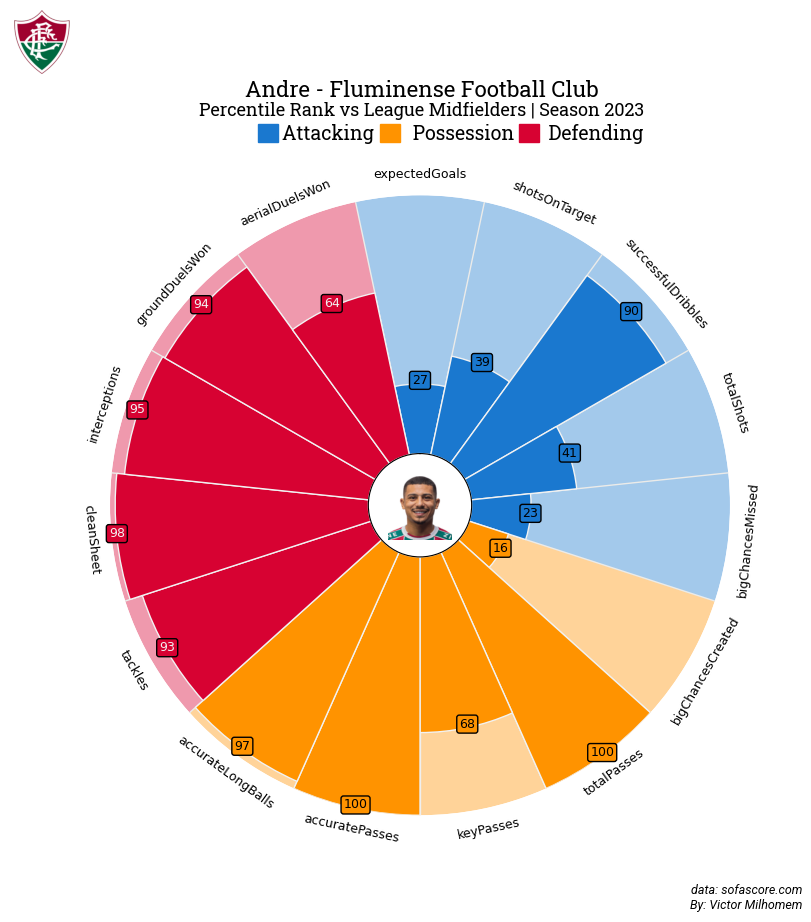

In [11]:
player_id = 1035996
team_id = 1961
player = get_player(player_id, merged_df, cols_filter)
values = calculate_percintiles(params, merged_df, player)

# Define your parameters
slice_colors = ["#1A78CF"] * 5 + ["#FF9300"] * 5 + ["#D70232"] * 5
text_colors = ["#000000"] * 10 + ["#F2F2F2"] * 5
player_image_path = merged_df.loc[(merged_df['player.id'] == player_id)]['player.image'].values[0]

team_image_path = teams_info_df.loc[(teams_info_df['team.id'] == team_id)]['team.image'].values[0]

#open image
player_image = Image.open(urlopen(player_image_path))
team_image = Image.open(urlopen(team_image_path))


# Create the PyPizza plot
title = "Andre - Fluminense Football Club"
subtitle = "Percentile Rank vs League Midfielders | Season 2023"

create_pizza_plot(values, params, title, subtitle, slice_colors, text_colors, player_image, team_image)
plt.show()